In [22]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

n_seq   = 1
n_steps = 30
n_features = 3

In [23]:
dataset = pd.read_csv("/home/xianjia/Workspace/temp/uwb_ranging_refine_with_spatial_detection/train_newdata.csv", delimiter=',')
# print(dataset.head)

dataset_selected = dataset[["node1", "node2", "uwb_range", "tb_node1_yaw", "tb_node2_yaw",  "error"]] #"mocap_range",

In [24]:
uwb_pair = [(1,4), (2,4), (3,4),(4,5),(1,2), (1,3), (1,5), (2,3), (2,4), (2,5), (3,5)]
uwb_data = []
for up in uwb_pair:
    rslt_df = dataset_selected.loc[dataset_selected['node1'] == up[0]]
    rslt_df_new = rslt_df.loc[rslt_df['node2'] == up[1]]
    uwb_data.append(rslt_df_new[["uwb_range", "tb_node1_yaw", "tb_node2_yaw",  "error"]].iloc[:,:].values)

print(uwb_data[1].shape)

(3375, 4)


In [25]:
X_train = []
y_train = []
for inx, dataset_train in enumerate(uwb_data):
    x_temp = []
    y_temp = []
    for i in range(n_steps,dataset_train.shape[0]):
        x_temp.append(dataset_train[i-n_steps:i,0:3])
        y_temp.append(dataset_train[i,3:])
    x_temp, y_temp = np.array(x_temp), np.array(y_temp)
    # print(np.array(x_temp).shape, np.array(y_temp).shape)
    # X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps, n_features))
    X_train.append(x_temp)
    y_train.append(y_temp)
X_train, y_train = np.array(X_train), np.array(y_train)

n_seq   = 3
n_steps = 10
n_features = 3
for inx in range(X_train.shape[0]):
    X_train[inx] = X_train[inx].reshape(X_train[inx].shape[0], n_seq, 1, n_steps, n_features)
    print(X_train[inx].shape)
    # y_train.append(y_temp.reshape(y_temp.shape[0], n_seq, 1, n_steps, n_features))

# print(X_train[1].shape, y_train[1].shape)

(3345, 3, 1, 10, 3)
(3345, 3, 1, 10, 3)
(3345, 3, 1, 10, 3)
(3345, 3, 1, 10, 3)
(3346, 3, 1, 10, 3)
(3345, 3, 1, 10, 3)
(3345, 3, 1, 10, 3)
(3345, 3, 1, 10, 3)
(3345, 3, 1, 10, 3)
(3345, 3, 1, 10, 3)
(3345, 3, 1, 10, 3)


<ipython-input-25-e473b785bc54>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train, y_train = np.array(X_train), np.array(y_train)


In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, ConvLSTM2D, Flatten
import tensorflow as     tf

In [27]:
# models
lstm_models = []
for inx in range(X_train.shape[0]):
    regressor = Sequential()
    regressor.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
    regressor.add(Flatten())
    regressor.add(Dense(1))
    regressor.compile(optimizer='adam', loss='mse')
    lstm_models.append(regressor)

In [28]:
history_list = []
earlyStopCallBack = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)
for inx, lm in enumerate(lstm_models):
    print(f"------------ In data pair {inx} --------------")
    history = lm.fit(X_train[inx], y_train[inx], epochs=100, batch_size=16, validation_split=0.3, callbacks=[earlyStopCallBack] )
    history_list.append(history)
    
print(f"------------ Training Ended --------------")

------------ In data pair 0 --------------
Epoch 1/100
147/147 [==============================] - 5s 12ms/step - loss: 0.0036 - val_loss: 1.2513e-04
Epoch 2/100
147/147 [==============================] - 2s 10ms/step - loss: 0.0023 - val_loss: 0.0057
Epoch 3/100
147/147 [==============================] - 2s 11ms/step - loss: 0.0024 - val_loss: 3.9945e-07
Epoch 4/100
147/147 [==============================] - 2s 11ms/step - loss: 0.0021 - val_loss: 1.7503e-04
Epoch 5/100
147/147 [==============================] - 2s 11ms/step - loss: 0.0019 - val_loss: 8.5544e-05
Epoch 6/100
147/147 [==============================] - 2s 11ms/step - loss: 0.0019 - val_loss: 7.6825e-05
Epoch 7/100
147/147 [==============================] - 2s 10ms/step - loss: 0.0018 - val_loss: 3.9610e-05
Epoch 8/100
147/147 [==============================] - 2s 11ms/step - loss: 0.0018 - val_loss: 3.2840e-05
Epoch 9/100
147/147 [==============================] - 2s 10ms/step - loss: 0.0017 - val_loss: 8.2732e-05
Epoch 1

dict_keys(['loss', 'val_loss'])


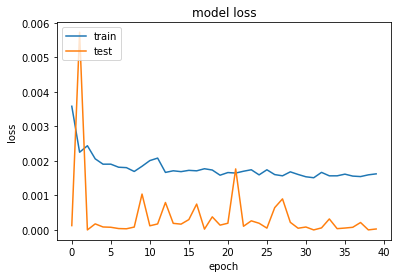

dict_keys(['loss', 'val_loss'])


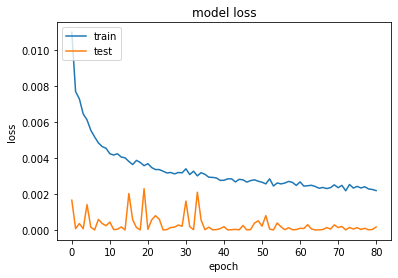

dict_keys(['loss', 'val_loss'])


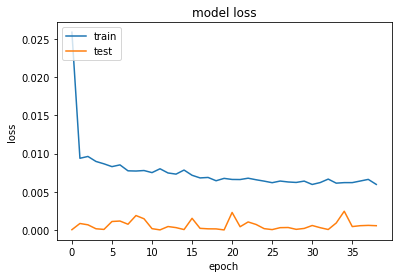

dict_keys(['loss', 'val_loss'])


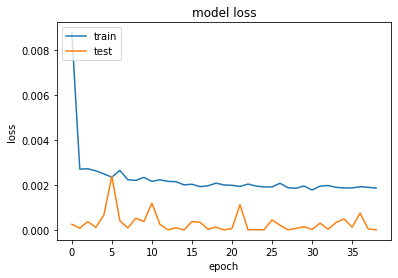

dict_keys(['loss', 'val_loss'])


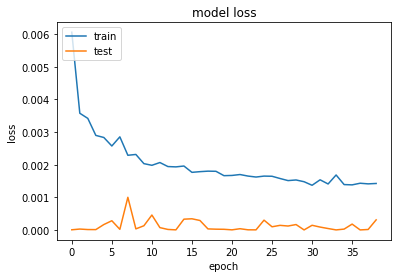

dict_keys(['loss', 'val_loss'])


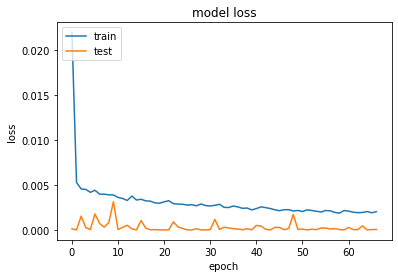

dict_keys(['loss', 'val_loss'])


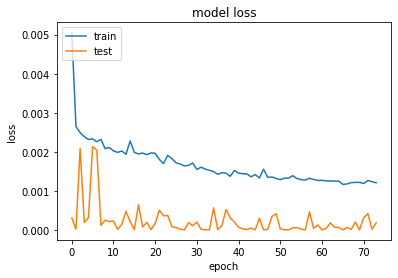

dict_keys(['loss', 'val_loss'])


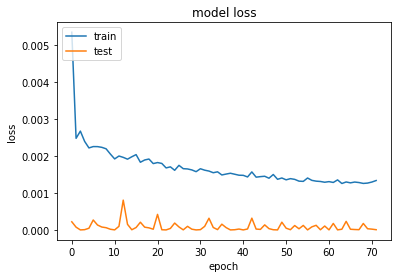

dict_keys(['loss', 'val_loss'])


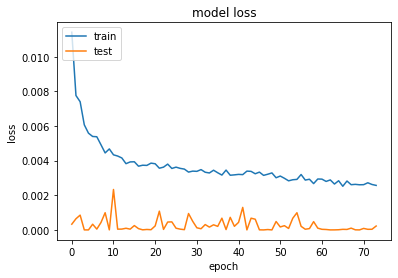

dict_keys(['loss', 'val_loss'])


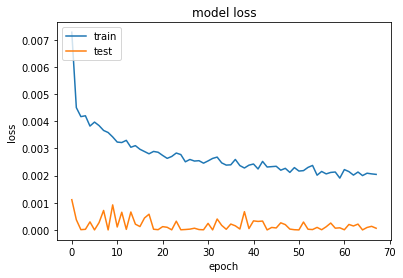

dict_keys(['loss', 'val_loss'])


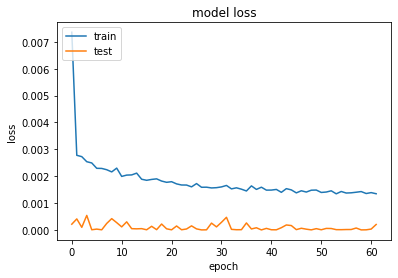

In [32]:
for history in history_list:
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
for history in history_list:
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [35]:
dataset = pd.read_csv("/home/xianjia/Workspace/temp/uwb_ranging_refine_with_spatial_detection/test_newdata.csv", delimiter=',')
# print(dataset.head)

uwb_pair = [(1,4), (2,4), (3,4),(4,5),(1,2), (1,3), (1,5), (2,3), (2,4), (2,5), (3,5)]
uwb_data_test = []
for up in uwb_pair:
    rslt_df = dataset.loc[dataset['node1'] == up[0]]
    rslt_df_new = rslt_df.loc[rslt_df['node2'] == up[1]]
    uwb_data_test.append(rslt_df_new[["uwb_range", "tb_node1_yaw", "tb_node2_yaw",  "error"]].iloc[:200,:].values)

print(uwb_data_test[1].shape)


X_test = []
y_test = []
n_steps = 30
for inx, dataset_test in enumerate(uwb_data_test):
    x_temp = []
    y_temp = []
    for i in range(n_steps,dataset_test.shape[0]):
        x_temp.append(dataset_test[i-n_steps:i,0:3])
        y_temp.append(dataset_test[i,3:])
    print(np.array(x_temp).shape, np.array(y_temp).shape)
    X_test.append(np.array(x_temp))
    y_test.append(np.array(y_temp))
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_test[1].shape, y_test[1].shape)

n_steps = 10
Predicted_X = []
for inx in range(len(lstm_models)):
    predict_x = lstm_models[inx].predict(X_test[inx].reshape(X_test[inx].shape[0], n_seq, 1, n_steps, n_features), verbose=0)
    Predicted_X.append(predict_x)
    mse = tf.keras.losses.MeanSquaredError()
    print(mse(y_test[inx], predict_x).numpy())


for inx in range(len(lstm_models)):
    lstm_models[inx].save('/home/xianjia/Workspace/temp/lstm_ws/comparisons/results_lstm/convlstm_uwb_{}'.format(inx))


(200, 4)
(170, 30, 3) (170, 1)
(170, 30, 3) (170, 1)
(170, 30, 3) (170, 1)
(170, 30, 3) (170, 1)
(170, 30, 3) (170, 1)
(170, 30, 3) (170, 1)
(170, 30, 3) (170, 1)
(170, 30, 3) (170, 1)
(170, 30, 3) (170, 1)
(170, 30, 3) (170, 1)
(170, 30, 3) (170, 1)
(170, 30, 3) (170, 1)
0.00497516
0.005573897
0.0075195907
0.0061801355
0.019629505
0.011096034
0.029035447
0.004455844
0.0031587675
0.010029621
0.011060881
INFO:tensorflow:Assets written to: /home/xianjia/Workspace/temp/lstm_ws/comparisons/results_lstm/convlstm_uwb_0/assets
INFO:tensorflow:Assets written to: /home/xianjia/Workspace/temp/lstm_ws/comparisons/results_lstm/convlstm_uwb_1/assets
INFO:tensorflow:Assets written to: /home/xianjia/Workspace/temp/lstm_ws/comparisons/results_lstm/convlstm_uwb_2/assets
INFO:tensorflow:Assets written to: /home/xianjia/Workspace/temp/lstm_ws/comparisons/results_lstm/convlstm_uwb_3/assets
INFO:tensorflow:Assets written to: /home/xianjia/Workspace/temp/lstm_ws/comparisons/results_lstm/convlstm_uwb_4/asset

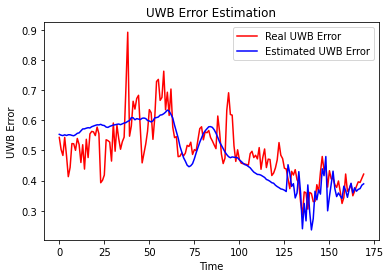

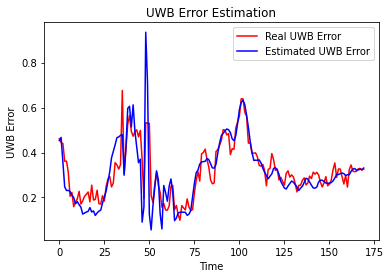

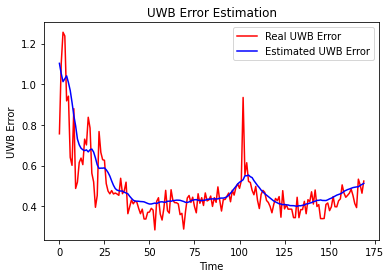

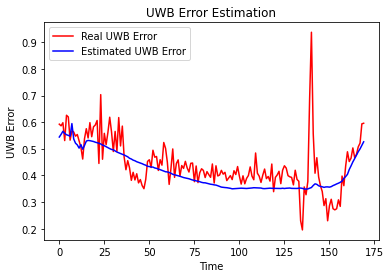

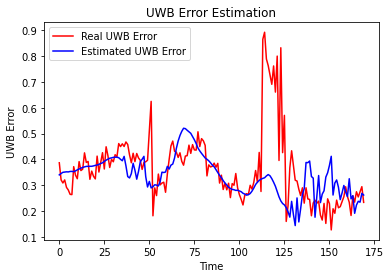

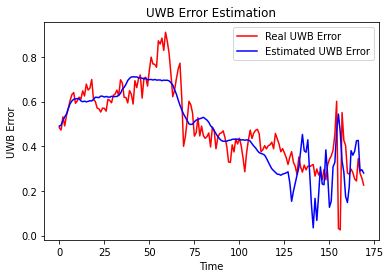

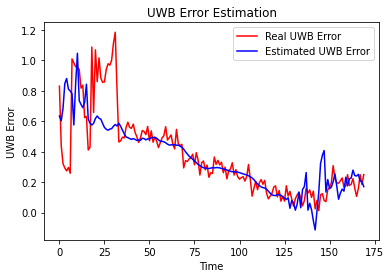

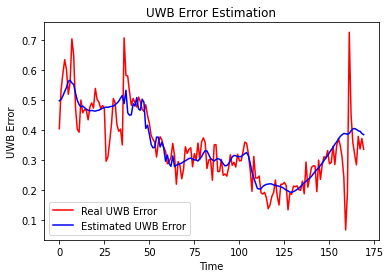

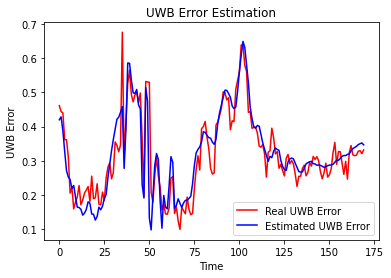

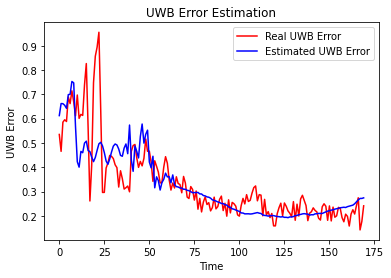

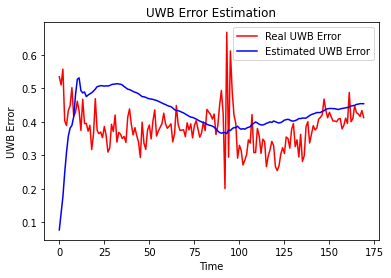

In [36]:
for p in range(len(Predicted_X)):
    plt.plot(y_test[p], color='red', label= 'Real UWB Error')
    plt.plot(Predicted_X[p], color='blue', label='Estimated UWB Error')
    plt.title("UWB Error Estimation")
    plt.xlabel('Time')
    plt.ylabel('UWB Error')
    plt.legend()
    plt.show()